#### 引入与 Area 类定义

In [29]:
import cv2
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

In [10]:
class Area:
    def __init__(self, left, right, up, down, area_level, val):
        self.left = left
        self.right = right
        self.up = up
        self.down = down
        self.val = val
        self.area_level = area_level
        self.area = (down - up) * (right - left)

    def __cmp__(self, other):
        if self.val < other.val:
            return -1
        elif self.val == other.val:
            return 0
        else:
            return 1

    def __lt__(self, other):  
        if self.val < other.val:
            return True
        else:
            return False
        
    def __str__(self):
        return "Area (%d, %d, %d, %d, %d)'s value is %.3f" %\
    (self.left, self.right, self.up, self.down, self.area_level, self.val)

####  判断一块区域是否值得被框选

In [4]:
# 统计 matrix 区域中大于 threshold 的元素个数
def elements_gt_threshold(matrix, threshold=200):
    count = 0
    h, w = matrix.shape
    for i in range(h):
        for j in range(w):
            if matrix[i, j] > threshold:
                count += 1
    return count

In [7]:
def get_result_from_size_list(img_path, size_list):
    # size_list element = (h, w, area_level)
    img = cv2.imread(img_path, 0)
    result_list = []
    for ele in size_list:
        rect_h, rect_w, area_level = ele
        img_h, img_w = img.shape
        area_list = []
        
        threshold = 0.15 if area_level <= 256 else 0.1
        up_down_margin = math.ceil(rect_h / 2)
        left_right_margin = math.ceil(rect_w / 2)
        for i in tqdm(range(up_down_margin, img_h - up_down_margin)):
            for j in range(left_right_margin, img_w - left_right_margin):
                tal = rect_h * rect_w * threshold
                left = max(j - int(rect_w/2), 0)
                right = min(j + int(rect_w/2), img_w)
                up = max(i - int(rect_h / 2), 0)
                down = min(i + int(rect_h / 2), img_h)
                result = elements_gt_threshold(img[up:down, left:right])

                if result > tal:
                    area = Area(left, right, up, down,
                                area_level, result/(rect_h * rect_w))
                    area_list.append(area)
        result_list.append(area_list)
    return result_list

In [11]:
size_list = [(16, 16, 256), (30, 60, 2048), (51, 77, 4096)]
result_list = get_result_from_size_list('90_4_down.jpg', size_list)

100%|██████████| 116/116 [02:20<00:00,  1.18s/it]


In [12]:
small_list = result_list[0].copy()
mid_list = result_list[1].copy()
large_list = result_list[2].copy()
print(len(small_list))
print(len(mid_list))
print(len(large_list))

2220
3953
1557


#### 使用 nms 删除冗余框

In [48]:
def is_redundant(area1, area2, same_level=True):
    ratio = 0
    w = 0
    h = 0
    if (area1.left >= area2.left and area1.left < area2.right):
        w = min(area2.right, area1.right) - area1.left
        h = min(area1.down, area2.down) - max(area1.up, area2.up)
    elif (area1.up >= area2.up and area1.up < area2.down):
        h = min(area2.down, area1.down) - area1.up
        w = min(area1.right, area2.right) - max(area1.left, area2.left)
    elif (area2.left >= area1.left and area2.left < area1.right):
        w = min(area2.right, area1.right) - area2.left
        h = min(area1.down, area2.down) - max(area1.up, area2.up)
    elif (area2.up >= area1.up and area2.up < area1.down):
        h = min(area2.down, area1.down) - area2.up
        w = min(area1.right, area2.right) - max(area1.left, area2.left)
    
    if same_level:
        ratio = (w * h) / (area1.area + area2.area - w * h)
        th = 0.1
    else:
        th = 0.3
        if area1.area_level > area2.area_level:
            ratio = (w * h) / area2.area
        else:
            ratio = (w * h) / area1.area
    return ratio >= th

In [49]:
# 对于同一个 area_level 的框，按得分排序，然后 nms 最小的
def sort_and_nms_1(area_list):
    area_list_copy = area_list.copy()
    area_list_copy.sort(reverse=True)
    i = 0
    while i < (len(area_list_copy) - 1):
        first_area = area_list_copy[i]
        j = i + 1
        while j < len(area_list_copy):
            second_area = area_list_copy[j]
            if is_redundant(first_area, second_area):
                area_list_copy.remove(second_area)
            else:
                j += 1
        i += 1
    return area_list_copy

In [50]:
# 对于不同 level 的，smaller_list 必须是已经 merge 好了的
# 遵循先小后大的 merge 顺序
def merge_and_nms_2(smaller_list, larger_list):
    smaller_list_copy = smaller_list.copy()
    for larger_area in larger_list:
        i = 0
        while i < len(smaller_list_copy):
            smaller_area = smaller_list_copy[i]
            if is_redundant(larger_area, smaller_area, same_level=False):
                smaller_list_copy.remove(smaller_area)
            else:
                i += 1
    return smaller_list_copy + larger_list

In [32]:
area1 = Area(0, 3, 0, 3,9, 1)
area2 = Area(1, 4, 1, 4,9, 0.5)
area3 = Area(0, 3, 1, 4,9, 0.75)
area4 = Area(1, 4, 0, 3,9, 0.5)
area5 = Area(5, 6, 5, 6, 1, 1)
area_list = [area2, area3, area4, area1, area5]
# area_list.remove(area3)
# len(area_list)
nms1 = sort_and_nms_1(area_list)
for ele in nms1:
    print(ele)

Area (0, 3, 0, 3, 9)'s value is 1.000
Area (5, 6, 5, 6, 1)'s value is 1.000
Area (1, 4, 1, 4, 9)'s value is 0.500


In [33]:
area1 = Area(0, 3, 0, 3, 9, 1)
area2 = Area(4, 7, 4, 7, 9, 1)
area3 = Area(0, 4, 0, 4, 16, 0.7)
area4 = Area(4, 8, 4, 8, 16, 0.75)
smaller_list = [area1, area2]
larger_list = [area3, area4]
# area_list.remove(area3)
# len(area_list)
nms2 = merge_and_nms_2(smaller_list, larger_list)
for ele in nms2:
    print(ele)

Area (0, 4, 0, 4, 16)'s value is 0.700
Area (4, 8, 4, 8, 16)'s value is 0.750


#### 在图上以方框标识结果

In [62]:
color = (155)
thickness = 2

In [63]:
small_nms1 = sort_and_nms_1(small_list)
print(len(small_nms1))
img_small_nms1 = cv2.imread('90_4_down.jpg', 0)

for i in range(len(small_nms1)): 
    pos = (small_nms1[i].left, small_nms1[i].right, small_nms1[i].up, small_nms1[i].down)
    cv2.rectangle(img_small_nms1, (pos[0], pos[2]), (pos[1], pos[3]), color, thickness)

img_small = cv2.imread('90_4_down.jpg', 0)
for i in range(len(small_list)): 
    pos = (small_list[i].left, small_list[i].right, small_list[i].up, small_list[i].down)
    cv2.rectangle(img_small, (pos[0], pos[2]), (pos[1], pos[3]), color, thickness)

12


In [65]:
img_mid = cv2.imread('90_4_down.jpg', 0)
for i in range(len(mid_list)): 
    pos = (mid_list[i].left, mid_list[i].right, mid_list[i].up, mid_list[i].down)
    cv2.rectangle(img_mid, (pos[0], pos[2]), (pos[1], pos[3]), color, thickness)
img_mid_nms1 = cv2.imread('90_4_down.jpg', 0)
mid_nms1 = sort_and_nms_1(mid_list)
print(len(mid_nms1))
for i in range(len(mid_nms1)): 
    pos = (mid_nms1[i].left, mid_nms1[i].right, mid_nms1[i].up, mid_nms1[i].down)
    cv2.rectangle(img_mid_nms1, (pos[0], pos[2]), (pos[1], pos[3]), color, thickness)

3


In [66]:
img_large = cv2.imread('90_4_down.jpg', 0)
for i in range(len(large_list)): 
    pos = (large_list[i].left, large_list[i].right, large_list[i].up, large_list[i].down)
    cv2.rectangle(img_large, (pos[0], pos[2]), (pos[1], pos[3]), color, thickness)
img_large_nms1 = cv2.imread('90_4_down.jpg', 0)
large_nms1 = sort_and_nms_1(large_list)
print(len(large_nms1))
for i in range(len(large_nms1)): 
    pos = (large_nms1[i].left, large_nms1[i].right, large_nms1[i].up, large_nms1[i].down)
    cv2.rectangle(img_large_nms1, (pos[0], pos[2]), (pos[1], pos[3]), color, thickness)

1


In [67]:
img_small_mid_nms2 = cv2.imread('90_4_down.jpg', 0)
small_mid_nms2 = merge_and_nms_2(small_nms1, mid_nms1)
print(len(mid_nms1) + len(small_nms1))
print(len(small_mid_nms2))
for i in range(len(small_mid_nms2)): 
    pos = (small_mid_nms2[i].left, small_mid_nms2[i].right, 
           small_mid_nms2[i].up, small_mid_nms2[i].down)
    cv2.rectangle(img_small_mid_nms2, 
                  (pos[0], pos[2]), (pos[1], pos[3]), color, thickness)
img_small_mid_large_nms2 = cv2.imread('90_4_down.jpg', 0)
small_mid_large_nms2 = merge_and_nms_2(small_mid_nms2, large_nms1)
print(len(small_mid_nms2) + len(large_nms1))
print(len(small_mid_large_nms2))
for i in range(len(small_mid_large_nms2)): 
    pos = (small_mid_large_nms2[i].left, small_mid_large_nms2[i].right, 
           small_mid_large_nms2[i].up, small_mid_large_nms2[i].down)
    cv2.rectangle(img_small_mid_large_nms2, 
                  (pos[0], pos[2]), (pos[1], pos[3]), color, thickness)

15
4
5
3


#### plot 展示与保存

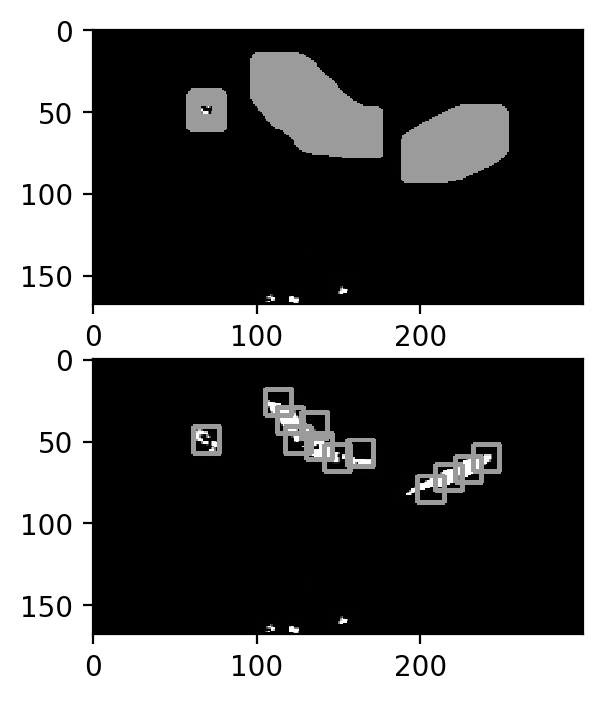

In [64]:
plt.figure(dpi=200)
plt.subplot(2,1,1)
plt.imshow(img_small, cmap=plt.cm.gray)

plt.subplot(2,1,2)
plt.imshow(img_small_nms1, cmap=plt.cm.gray)

plt.show()

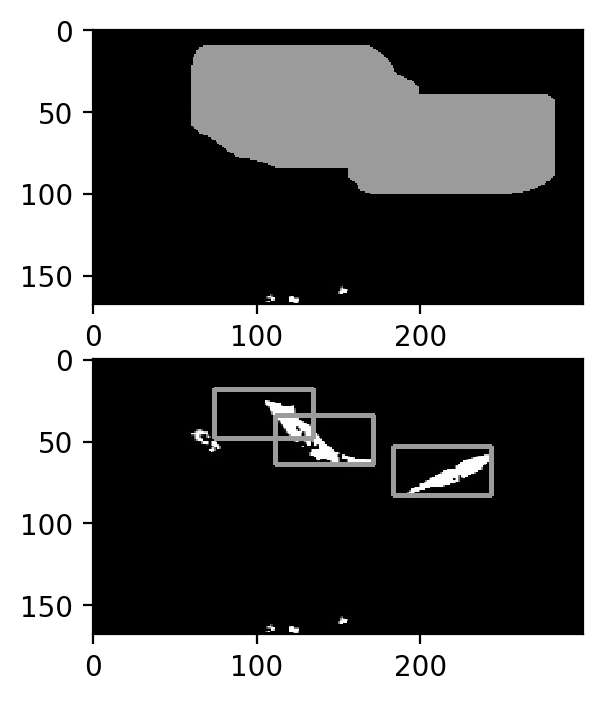

In [68]:
plt.figure(dpi=200)
plt.subplot(2,1,1)
plt.imshow(img_mid, cmap=plt.cm.gray)

plt.subplot(2,1,2)
plt.imshow(img_mid_nms1, cmap=plt.cm.gray)

plt.show()

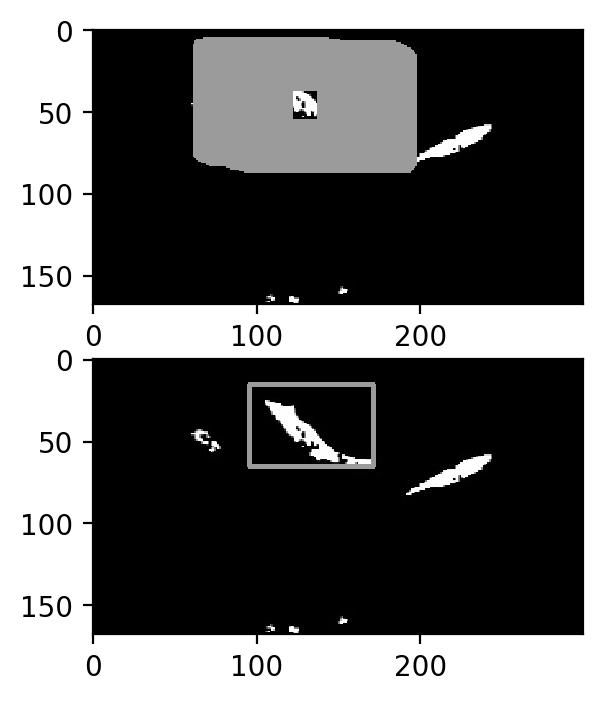

In [69]:
plt.figure(dpi=200)
plt.subplot(2,1,1)
plt.imshow(img_large, cmap=plt.cm.gray)

plt.subplot(2,1,2)
plt.imshow(img_large_nms1, cmap=plt.cm.gray)

plt.show()

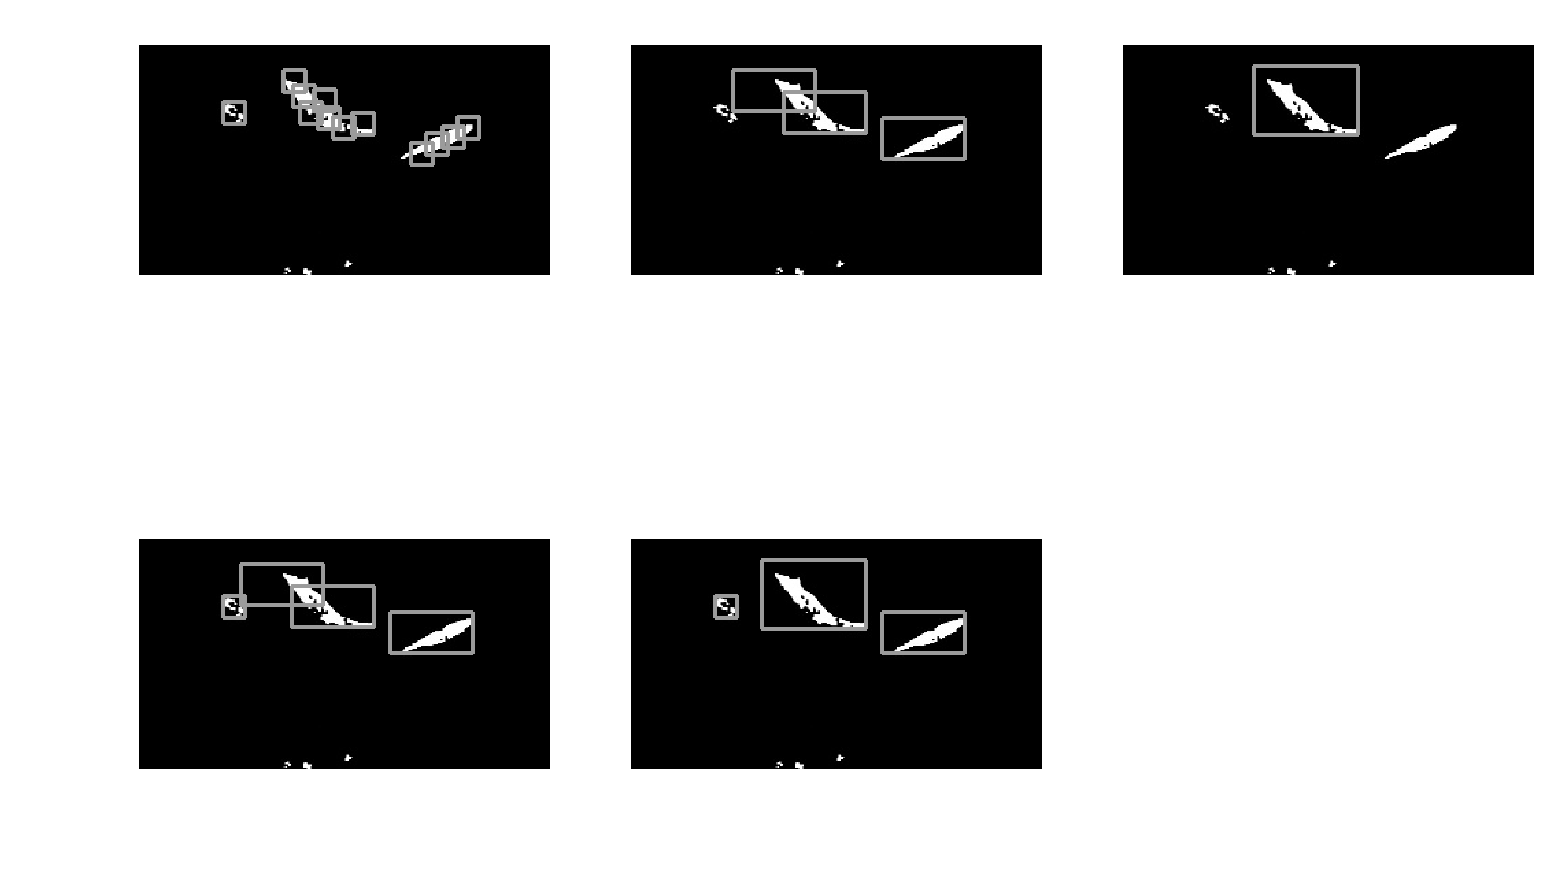

In [70]:
plt.figure(dpi=300)

plt.subplot(2,3,1)
plt.imshow(img_small_nms1, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(img_mid_nms1, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(img_large_nms1, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(img_small_mid_nms2, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(img_small_mid_large_nms2, cmap=plt.cm.gray)
plt.axis('off')

plt.show()

In [83]:
cv2.imwrite('90_4_down_small.jpg', img_small)
cv2.imwrite('90_4_down_small_nms1.jpg', img_small_nms1)
cv2.imwrite('90_4_down_mid.jpg', img_mid)
cv2.imwrite('90_4_down_mid_nms1.jpg', img_mid_nms1)
cv2.imwrite('90_4_down_large.jpg', img_large)
cv2.imwrite('90_4_down_large_nms1.jpg', img_large_nms1)
cv2.imwrite('90_4_down_small_mid_nms2.jpg', img_small_mid_nms2)
cv2.imwrite('90_4_down_small_mid_large_nms2.jpg', img_small_mid_large_nms2)

True

#### 其他

In [48]:
cv2.imwrite('90_4_largebox.jpg', img)

True

In [78]:
img = cv2.imread('90_4_down.jpg', 0)
small_center = (70, 50)
mid_center = (220, 70)
pos_mid = (95, 171, 15, 65)
pos_left = (62, 78, 42, 58)
pos_right = (188, 252, 38, 102)
cv2.rectangle(img, (pos_mid[0], pos_mid[2]), (pos_mid[1], pos_mid[3]), (155), 1)
cv2.rectangle(img, (pos_left[0], pos_left[2]), (pos_left[1], pos_left[3]), (155), 1)
cv2.rectangle(img, (pos_right[0], pos_right[2]), (pos_right[1], pos_right[3]), (155), 1)
cv2.imwrite('90_4_box_res.jpg', img)

True

In [81]:
img = cv2.imread('uw/uw1/241.jpg')

In [82]:
img.shape

(720, 1280, 3)

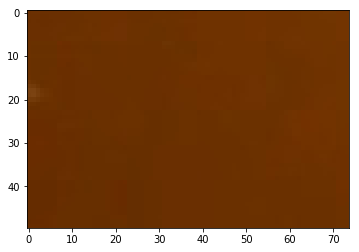

In [83]:
crop_mid = img[pos_mid[2]: pos_mid[3], pos_mid[0]:pos_mid[1]]
plt.figure()
plt.imshow(crop_mid)
plt.show()

In [84]:
pos_mid

(105, 179, 25, 75)